# Importando as bibliotecas:

In [ ]:
pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 45.2 MB/s eta 0:00:00


In [ ]:
# Importando as libs do pytorch:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split

# Utilitários:
import onnx
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Configurando o uso de gpu: (se disponível)

Antes vá em: (Editar -> Configurações de notebook) e escolha uma opção diferente de cpu

In [ ]:
# Confirmando que estamos utilizando GPU:
!nvidia-smi

Wed May 15 18:16:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Definindo o dispositivo:
if torch.cuda.is_available():
    print("GPU disponível. Usando GPU.")
    device = torch.device('cuda')
else:
    print("GPU não disponível. Usando CPU.")
    device = torch.device('cpu')

GPU disponível. Usando GPU.


# Baixando e preparando nosso dataset:

In [ ]:
# Definindo a transformação de normalização e convertendo para tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Baixando o conjunto de dados MNIST (dígitos) e aplicando a transformação
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16214511.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 488365.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 944259.21it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10404439.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Dividindo os dados em conjuntos de treinamento e validação usando train_test_split do sklearn
train_data, val_data = train_test_split(train_dataset, test_size=0.1, random_state=42)

In [ ]:
# Criando os DataLoaders para treinamento, validação e teste
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Tamanho do conjunto de dados de treinamento:", len(train_data))
print("Tamanho do conjunto de dados de validação:", len(val_data))
print("Tamanho do conjunto de dados de teste:", len(test_dataset))

Tamanho do conjunto de dados de treinamento: 54000
Tamanho do conjunto de dados de validação: 6000
Tamanho do conjunto de dados de teste: 10000


# Visualizando nossos dados:

In [ ]:
# Função para converter de tensor para imagem:
def converter_imagem(tensor):
  imagem = tensor.clone().detach().numpy()
  imagem = imagem.transpose(1,2,0)
  imagem = imagem.clip(0,1)
  return imagem

# Função para exibir várias imagens
def grade_imagens(train_loader, string_color):
  for batch in train_loader:
      imagens, rotulos = batch
  fig = plt.figure(figsize=(6,4))
  fig.subplots_adjust(hspace=1)

  for idx in np.arange(4):
    ax = fig.add_subplot(2,2,idx+1)
    plt.imshow(converter_imagem(imagens[idx]), cmap=string_color)
    ax.set_title(f"Label: {rotulos[idx].item()}")
    ax.set_xticks([])
    ax.set_yticks([])

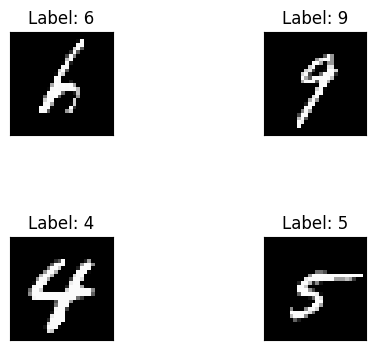

In [ ]:
# Visualizando algumas imagens do nosso dataset:

grade_imagens(train_loader, "gray")

# Definindo o nosso modelo:

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()

        # Camadas da rede neural
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()           # Camada que converte a entrada para um vetor
        self.fc1 = nn.Linear(28 * 28, 128)    # Camada de entrada -> intermediária
        self.relu = nn.ReLU()                 # Função de ativação
        self.fc2 = nn.Linear(128, 10)         # Camada intermediária -> saída

    # Definindo a passagem dos dados
    def forward(self, x):
        # Passagem dos dados através das camadas
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Definindo hiperparâmetros, otimizadores, critério e instânciando o modelo:

In [ ]:
modelo = Modelo()                                                     # Intânciando nosso modelo
criterio = nn.CrossEntropyLoss()                                      # Definindo o critério para o cálculo da perca
taxa_de_aprendizado = 0.001                                           # Definindo o valor da nossa taxa de aprendizado
otimizador = optim.Adam(modelo.parameters(), lr=taxa_de_aprendizado)  # Definindo qual otimizador utilizaremos para atualizar os pesos

In [ ]:
# Move o modelo para a GPU, se disponível
modelo = modelo.to(device)

# Visualizando a estrutura do modelo
print(modelo)

Modelo(
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Definindo nossas funções de treino, validação e teste:

In [ ]:
def Validacao(modelo, val_loader, criterio, device):
    modelo.eval()                                   # Define o modelo no modo de avaliação
    total_acertos = 0
    total_exemplos = 0
    epoch_loss = 0.0

    with torch.no_grad():                           # Desativa o cálculo de gradientes durante a validação
        for batch in val_loader:
            imagens, rotulos = batch
            imagens, rotulos = imagens.to(device), rotulos.to(device)
            saidas = modelo(imagens)
            loss = criterio(saidas, rotulos)
            epoch_loss += loss.item()

            _, previsoes = torch.max(saidas, 1)    # Obtém as previsões do modelo
            total_acertos += (previsoes == rotulos).sum().item()
            total_exemplos += rotulos.size(0)

    # Calcula a acurácia e a loss média para a época de validação
    avg_epoch_loss = epoch_loss / len(val_loader)
    accuracy = total_acertos / total_exemplos

    print(f'Loss de validação média: {avg_epoch_loss:.3f}, Acurácia de validação: {accuracy:.3f}\n')
    modelo.train()  # Retorna o modelo ao modo de treinamento
    return avg_epoch_loss, accuracy

In [ ]:
def Treinamento(epocas, modelo, train_loader, val_loader, criterio, otimizador, device):
  train_losses = []
  train_accuracies = []
  valid_losses = []
  valid_accuracies = []
  inicio = time.time()
  for epoca in range(epocas):
      epoch_loss = 0.0
      correct_predictions = 0
      total_predictions = 0                                         # Inicializa/zera a loss para a época
      for batch in train_loader:                                      # Iterando sobre cada conjunto de dados no loader
          imagens, rotulos = batch
          imagens, rotulos = imagens.to(device), rotulos.to(device)   # Move os dados para a GPU, se disponível
          otimizador.zero_grad()                                      # Zerando o valor dos gradientes para não acumular
          saidas = modelo(imagens)                                    # Realizando as predições com o modelo
          loss = criterio(saidas, rotulos)                            # Calculando o erro na predição com o nosso critério
          loss.backward()                                             # Propagando o erro pela rede
          otimizador.step()                                           # Atualizando os pesos com o nosso otimizador
          epoch_loss += loss.item()                                   # Acumula a loss para a época

          _, previsoes = torch.max(saidas, 1)  # Obtém as previsões do modelo
          correct_predictions += (previsoes == rotulos).sum().item()
          total_predictions += rotulos.size(0)

      # Calculando a média da loss para a época
      avg_train_loss = epoch_loss / len(train_loader)
      train_accuracy = correct_predictions / total_predictions

      # Exibindo a loss média para a época
      print(f'Época {epoca + 1}/{epocas}:\nLoss de treinamento média: {avg_train_loss:.3f}, Acurácia de treinamento: {train_accuracy:.3f}')

      # Realiza a validação após cada época de treinamento
      avg_valid_loss, val_accuracy = Validacao(modelo, val_loader, criterio, device)

      train_losses.append(avg_train_loss)
      valid_losses.append(avg_valid_loss)
      train_accuracies.append(train_accuracy)
      valid_accuracies.append(val_accuracy)

  fim = time.time()
  print(f"Treinamento concluído em {fim-inicio:.2f} segundos")
  return modelo, train_losses, valid_losses, train_accuracies, valid_accuracies

In [ ]:
# Teste o modelo no conjunto de teste
def Teste_modelo(modelo, test_loader):
  modelo.eval()                                                     # Configurando o modelo para modo de avaliação (não alterar nenhuma parâmetro)
  corretos = 0
  total = 0
  with torch.no_grad():                                             # Congela a atualização dos gradientes (não mexer nos valores dos gradientes)
      for batch in test_loader:
          imagens, rotulos = batch
          imagens, rotulos = imagens.to(device), rotulos.to(device) # Move os dados para a GPU, se disponível
          saidas = modelo(imagens)
          _, previsao = torch.max(saidas.data, 1)
          total += rotulos.size(0)
          corretos += (previsao == rotulos).sum().item()

  acuracia = corretos / total
  print(f'Acurácia no teste: {acuracia * 100:.2f}%')

# Realizando treinamento e teste com o nosso modelo:

In [ ]:
# Definindo o número de épocas (vezes em que o modelo vai iterar sobre todo o conjunto de dados)
epocas = 5

# Treinamento do modelo
modelo, train_losses, valid_losses, train_accuracies, valid_accuracies = Treinamento(epocas, modelo, train_loader, val_loader, criterio, otimizador, device)

Época 1/5:
Loss de treinamento média: 0.562, Acurácia de treinamento: 0.830
Loss de validação média: 0.265, Acurácia de validação: 0.922

Época 2/5:
Loss de treinamento média: 0.357, Acurácia de treinamento: 0.892
Loss de validação média: 0.206, Acurácia de validação: 0.940

Época 3/5:
Loss de treinamento média: 0.314, Acurácia de treinamento: 0.905
Loss de validação média: 0.181, Acurácia de validação: 0.945

Época 4/5:
Loss de treinamento média: 0.287, Acurácia de treinamento: 0.913
Loss de validação média: 0.159, Acurácia de validação: 0.956

Época 5/5:
Loss de treinamento média: 0.276, Acurácia de treinamento: 0.916
Loss de validação média: 0.153, Acurácia de validação: 0.956

Treinamento concluído em 14.01 segundos


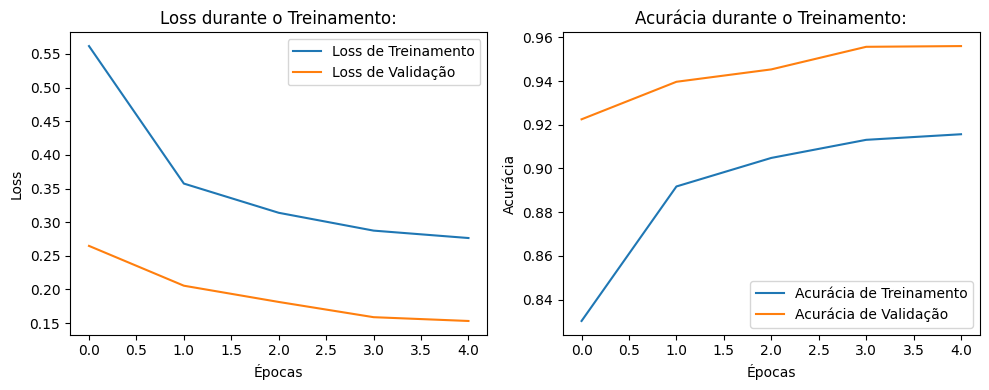

In [ ]:
# Definindo o tamanho da figura
plt.figure(figsize=(10, 4))

# Plotando as losses
plt.subplot(1, 2, 1)  # subplot com 1 linha, 2 colunas, este é o primeiro subplot
plt.plot(train_losses, label='Loss de Treinamento')
plt.plot(valid_losses, label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss durante o Treinamento:')
plt.legend()

# Plotando as acurácias
plt.subplot(1, 2, 2)  # subplot com 1 linha, 2 colunas, este é o segundo subplot
plt.plot(train_accuracies, label='Acurácia de Treinamento')
plt.plot(valid_accuracies, label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia durante o Treinamento:')
plt.legend()

# Mostrando os subplots
plt.tight_layout()
plt.show()

In [ ]:
# Avaliação do modelo criado
Teste_modelo(modelo, test_loader)

Acurácia no teste: 95.66%


# Visualizando uma predição em um dado separado:

In [ ]:
def exibir_predicao(modelo_escolhido, dataset):
    # Escolhendo uma imagem aleatória do conjunto de teste
    rand_idx = np.random.randint(len(dataset))
    image, label = dataset[rand_idx]

    # Adicionando uma dimensão para o lote
    image = image.unsqueeze(0)

    # Move a imagem para a GPU
    image = image.to(device)

    # Fazendo uma predição com o modelo_escolhido treinado
    modelo_escolhido.eval()
    with torch.no_grad():
        output = modelo_escolhido(image)  # Adiciona uma dimensão para o lote

    # Obtendo a classe prevista e a probabilidade associada
    predicted_probs = torch.softmax(output, dim=1)
    _, predicted_class = torch.max(output, 1)

    plt.imshow(image.cpu().squeeze(), cmap = 'gray')
    plt.title(f'Real: {label}, Predição: {predicted_class.item()}')
    plt.show()
    print(f"Probabilidade: {(predicted_probs.squeeze()[predicted_class.item()].item())*100:.2f}%")

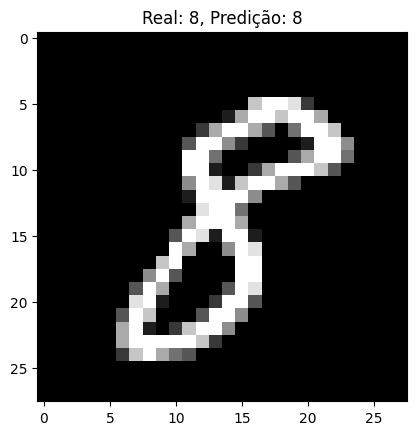

Probabilidade: 96.82%


In [ ]:
# Realiza predição e exibe
exibir_predicao(modelo,test_dataset)

# Salvando o nosso modelo treinado:

In [ ]:
def salvar_modelo(nome_modelo):
  # Especificando o caminho do diretório que você deseja criar
  caminho_diretorio = './modelos'

  # Verificar se o diretório não existe antes de criar
  if not os.path.exists(caminho_diretorio):
      os.makedirs(caminho_diretorio)
      print(f'Diretório {caminho_diretorio} criado com sucesso!')
  else:
      print(f'O diretório {caminho_diretorio} já existe.')

  # Especificando o caminho do arquivo onde você deseja salvar o modelo
  caminho_arquivo = './modelos/'+str(nome_modelo)+'.pth'

  # Salvar o modelo
  torch.save(modelo.state_dict(), caminho_arquivo)

def carrega_modelo(nome_modelo):
  caminho_arquivo = './modelos/'+str(nome_modelo)+'.pth'
  modelo_carregado = torch.load(caminho_arquivo)

In [ ]:
# Salvando o modelo treinado
nome_modelo = 'classificador_numeros'
salvar_modelo(nome_modelo)

Diretório ./modelos criado com sucesso!


In [ ]:
# Carregando o modelo
nome_modelo = 'classificador_numeros'
carrega_modelo(nome_modelo)

In [ ]:
# Se quiser baixar o arquivo .pth do modelo para a máquina local:
from google.colab import files
files.download('./modelos/classificador_numeros.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Salvando o modelo como ONNX(Open Neural Network Exchange):

In [ ]:
# Definir um exemplo de entrada
batch_size = 1
input_shape = (1, 28, 28)
dummy_input = torch.randn(batch_size, *input_shape)

In [ ]:
# Exportar o modelo para o formato ONNX
onnx_file_path = "modelo.onnx"
model_cpu = modelo.cpu()
torch.onnx.export(model_cpu, dummy_input, onnx_file_path, verbose=True)
print("Modelo exportado para ONNX com sucesso!")

Modelo exportado para ONNX com sucesso!


# Plotando os pesos da camada inicial-.oculta para visualizar os padrões de ativação:

### **Padrões claros e definidos**: Padrões claros e definidos podem indicar que o neurônio está aprendendo a detectar características específicas na entrada, como bordas, texturas, ou outras características importantes para o problema em questão.

### **Padrões de ruído**: Apenas ruído ou aleatória podem indicar indicar que o neurônio não está aprendendo nada útil e está, em vez disso, respondendo de maneira aleatória aos dados de entrada. Isso pode ser um sinal de que o treinamento da rede não está convergindo corretamente ou que a capacidade da rede é muito alta para o problema, levando à sobreajuste.

### **Padrões intermediários**: Padrões intermediários entre claros e definidos e puro ruído. Isso pode indicar que o neurônio está aprendendo a detectar características parciais ou menos distintas na entrada.

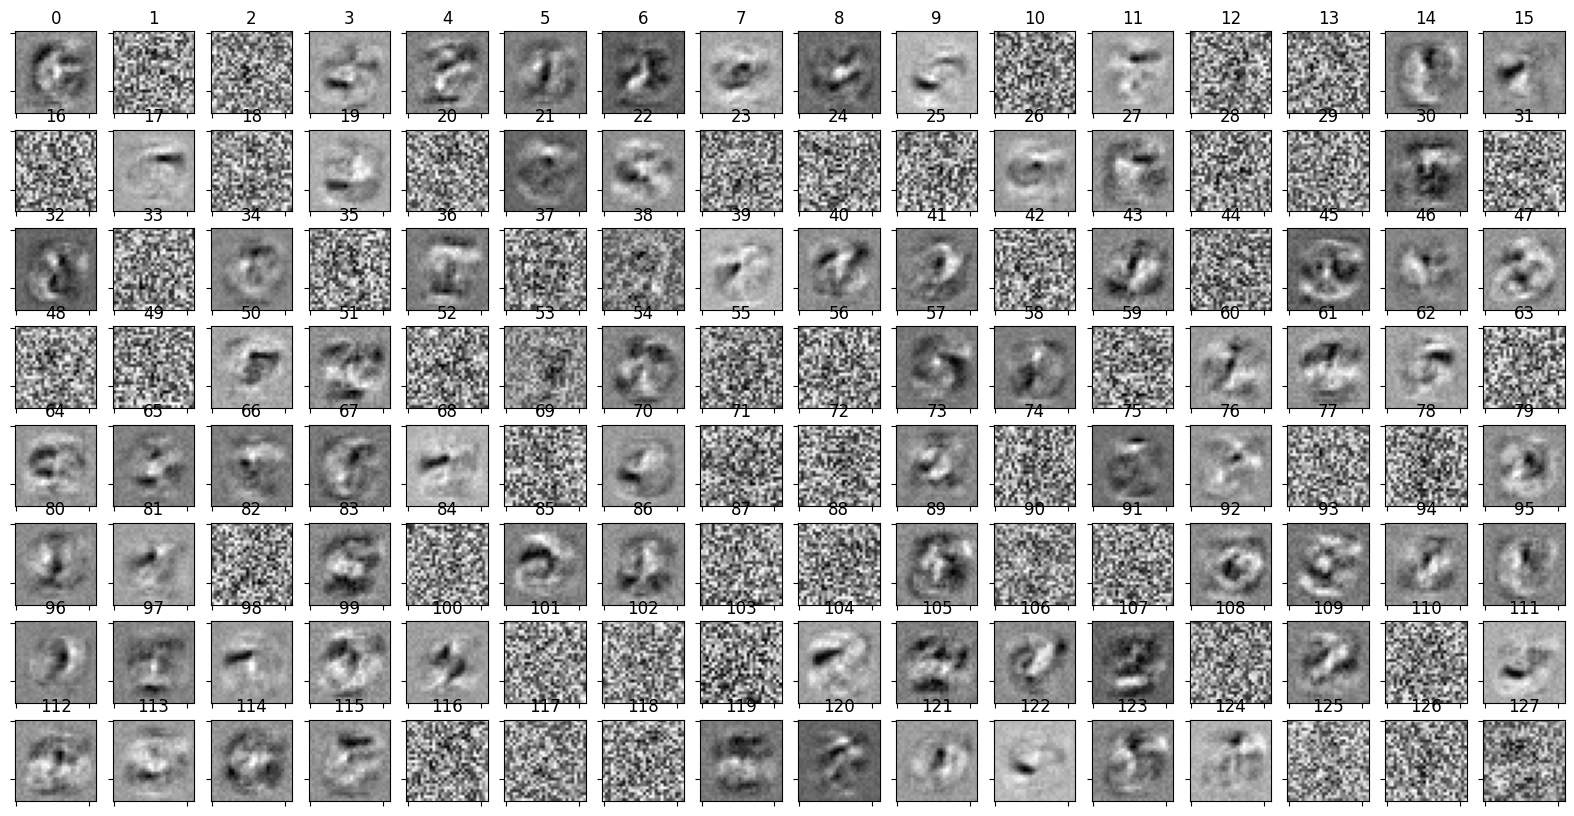

In [ ]:
# Capturando os pesos da primeira camada totalmente conectada:
linear_layer_weights = model_cpu.fc1.weight[:,:].detach().cpu().numpy()

plt.figure(figsize=(20, 10))  # AAjustando o tamanho da plotagem
for ix_w in range(128):  # Escolhendo o número de nós que queremos iterar
    tmp = linear_layer_weights[ix_w, :].reshape(28, 28)
    ax = plt.subplot(8, 16, ix_w + 1)  # Utilizando x linhas e y colunas para visualização
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title(str(ix_w))
    plt.imshow(tmp, cmap='gray')
plt.show()